In [1]:
#Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Polynomial Transformations

import itertools
import functools

def get_combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    #reduce(lambda x, y: x * y, items, [1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
    return functools.reduce(lambda x, y: x * y, items)

def polynomial_transform(x, degree, logging=False):
    # Converts to feature matrix.
    if x.ndim == 1:
        x = x[:, None]

    x_t = x.transpose() #transposes the feature matrix
    features = [np.ones(len(x))] # populates 1s as the first features

    if logging:
        print ("Input:", x)
    
    for degree in range(1, degree+1):
        for items in get_combinations(x_t, degree):
            features.append(compute_new_features(items))
            if logging:
                print (items, ":", compute_new_features(items))

    if logging:
        print(np.asarray(features).transpose())

    return np.asarray(features).transpose()

In [3]:
x = np.array([1,2,3])
polynomial_transform(x, degree=1)

array([[1., 1.],
       [1., 2.],
       [1., 3.]])

## Label Encoding

In [4]:
class LabelTransformer(object):
    """
    Label encoder decoder
    -----------------------

    Attributes:
        n_classes: int
                number of classes
    """

    def __init__(self, n_classes:int = None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)

    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices: np.ndarray):
        """
        encode class index into one-of-k code

        Parameters
        ----------------
        class_indices: (N,) np.ndarray
            non_negative class index
            elements must be integer in [0, n_classes)

        Returns
        ----------------
        (N, K) np.ndarray
                one-of-k encoding of input
        """

        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot: np.ndarray):
        """
        decode one-of-k code into class index

        Parameters
        -----------------
        onehot : (N, K) np.ndarray
            one-of-k code

        Returns
        ------------------
        (N,) np.ndarray
            class index
        """ 

        return np.argmax(onehot, axis=1)

In [5]:
binary_labels = LabelTransformer(2).encode(np.array([1,0,1,0]))
binary_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [6]:
multiclass_labels = LabelTransformer(3).encode(np.array([1,0,1,2]))
multiclass_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Least square classification implementation

In [7]:
class LeastSquareClassification(object):
    '''
    LSC Model
    ------------------------------------
    y = np.where(X@w >= 0, 1, 0)
    X: A feature matrix
    w: weight vector
    y; Label Vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 1000

    def predict(self, X:np.ndarray) -> np.ndarray:
        ''' Prediction of output label for a given input

            Args:  
                X: Feature matrix for given inputs

            Returns:
                y: Predicted label vector 

        '''
        # Check to make sure that the shapes are compatible
        assert X.shape[-1] == self.w.shape[0], f"X shape {X.shape} and w shape {self.w.shape}, are not compatible"
        return np.argmax(X @ self.w, axis=-1)

    def predict_internal(self, X:np.ndarray) -> np.ndarray:
        '''
        Prediction of output label for a given input

        Args:
            X: Feature matrix for given inputs

        Returns:
            y: Output label vector encoded in label encoder format
        '''

        #Check to make sure that the shapes are compatible
        assert X.shape[-1] == self.w.shape[0], f"X shape {X.shape} and w shape {self.w.shape}, are not compatible"
        return X @ self.w

    def loss(self, X: np.ndarray, y: np.ndarray, reg_rate: float) -> float:
        '''Calculates loss for a model based on known labels
    
        Args:
            X: Feature matrix for given inputs
            y: Output label vector as predicted by the given model
            w: Weight vector

        Returns:
            Loss
        '''

        err = self.predict_internal(X) - y
        #return (1/2) * (np.transpose(err) @ err)
        return (1/2) * (np.transpose(err) @ err) + (reg_rate/2) * (np.transpose(self.w) @ self.w)

    def rmse(self, X: np.ndarray, y: np.ndarray, reg_rate:float) -> float:
        '''Calculate root mean square error of prediction wrt actual label.
        
        Args:
            X: Feature matrix for the given inputs
            y: output label vector as predicted by the given model

        Returns:
            Loss
        '''

        return np.sqrt((2/X.shape[0]) * self.loss(X, y, reg_rate))

    def fit(self, X:np.ndarray, y:np.ndarray, reg_rate: float) -> float:
        '''Estimates parameters of the linear regression model with normal equation.
    
        Args: 
            X: Feature matrix for given inputs.
            y: Actual label vector.

        Returns:
            Weight vector
        '''
        self.w = np.zeros((X.shape[1]))
        eye = np.eye(np.size(X,1))
        self.w = np.linalg.solve(reg_rate * eye + X.T @ X, X.T @ y,)
        return self.w

    def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate: float) -> np.ndarray:
        '''Calculates gradients of loss dunction wrt weight vector on training set
    
        Arguments:

            X: Feature matrix for training data.
            y: Label vector for training data
            w: Weight vector

        Returns:
            A vector of gradients.
        '''
    
        return (np.transpose(X) @ (self.predict_internal(X) - y)) + reg_rate * self.w
    
    def update_weights(self, grad: np.ndarray, lr: float) -> np.ndarray:
        '''
        Updates the weights based on the gradient of loss function.

        Weight updates are carried out with the fiollowing formula:
            w_new := w_old - lr * grad

        Args:
            1. w: Weight vector
            2. grad: gradient of loss w.r.t w
            3. lr: learning rate

        Returns:
            Updated weight vector
        '''

        return (self.w - lr*grad)

    def learning_schedule(self, t) -> float:
        lr = (self.t0) / (t + self.t1)
        return lr

    def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float, reg_rate: float) -> np.ndarray:
        '''Estimates parameters of linear regression model through gradient descent.
    
        Arguments:
            X: Feature matrix for training data
            y: Label vector for training data
            lr: learning rate
            num_epochs: Number of training steps

        Returns:
            Weight vector: Final weight vector
            Error vector across different iterations
            Weight vectors acrss different iterations
        '''
        self.w = np.zeros((X.shape[1], y.shape[1])) # parameter vector initialised to zero
        self.w_all = [] #all paramenter across iterations
        self.err_all = [] # all arrors across iterations



        #Gradient descent loop
        for i in np.arange(0, num_epochs):

            #Gradient Calulation
            dJdW = self.calculate_gradient(X, y, reg_rate)

            self.w_all.append(self.w)

            #calculate arror due to the current weight vector:
            self.err_all.append(self.loss(X, y, 0))

            #Weight vector update.
            self.w = self.update_weights(dJdW, lr)

        return self.w
    
    def mbgd(self, X: np.ndarray, y: np.ndarray, num_epochs: int, batch_size: int, reg_rate: float) -> np.ndarray:

        '''Estimates parametrs of linear regression model through gradient descent.
    
        Args:
            1. X: Feature matrix for training data.
            2. y: Label vector for training data.
            3. num_iters: Number of iterations.

        Returns:
            Weight vector: Final weight vector
            Error vector across different iterations
         Weight vector acosss different iterations
        
        '''
        # Parameter vector initialised to [0,0]
        self.w = np.zeros((X.shape[1], y.shape[1]))
        
        self.w_all = [] # all parameters across iterations.
        self.err_all = [] # error across iterations

        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                xi = X_shuffled[i: i + batch_size]
                yi = y_shuffled[i: i + batch_size]
            
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi, yi, 0))

                dJdW = 2/batch_size * self.calculate_gradient(xi, yi, reg_rate)

                self.w = self.update_weights(dJdW, self.learning_schedule(mini_batch_id))
            
        return self.w
    
    def sgd(self, X: np.ndarray, y: np.ndarray, num_epochs: int, reg_rate: float) -> np.ndarray:

        '''Estimates parametrs of linear regression model through stochastic gradient descent.
    
        Args:
            1. X: Feature matrix for training data.
            2. y: Label vector for training data.
            3. num_epochs: Number of epochs.

        Returns:
            Weight vector: Final weight vector
            Error vector across different iterations
            Weight vector acosss different iterations
        '''

        self.w_all = [] # all parameters across iterations.
        self.err_all = [] # error across iterations

        # Parameter vector initialised to [0,0]
        self.w = np.zeros((X.shape[1], y.shape[1]))

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                xi = X[random_index: random_index + 1]
                yi = y[random_index: random_index + 1]
            
                self. err_all.append(self.loss(xi, yi, 0))
                self.w_all.append(self.w)

                gradients = 2 * self.calculate_gradient(xi, yi, reg_rate)
                lr = self.learning_schedule(epoch * X.shape[0] + i)

                self.w = self.update_weights(gradients, lr)
            

        return self.w

##Demonstration

We will demonstrate working on leasst square classification in following set ups:

1. Linearly seperable binary classification setup.
2. Linearly seperable binary classification seup with a few outlier points.
3. Multi-class classification with **k=3**.
4. Polynomial least square classification.

## Synthetic Data

In [8]:
def create_toy_data(add_outliers = False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1

    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 2.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(int)
    
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(int)

In [9]:
from sklearn.model_selection import train_test_split

def preprocess(add_class=False, add_outliers=False, degree=1):
    x, y = create_toy_data(add_outliers, add_class)
    x_poly = polynomial_transform(x, degree=degree)
    x_train, x_test, y_train, y_test =  train_test_split(x_poly, y)
    y_train_trans = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)
    return x_train, x_test, y_train, y_test, y_train_trans, y_test_trans 

In [10]:
# model visualisation

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def visualize_model(X_train, labels, lsc_obj, degree=1):
    
    f = plt.figure(figsize=(8, 8))

    #compute xlim and ylim
    x1_min = np.min(x_train[:, 1])
    x1_max = np.max(x_train[:, 1])
    x2_min = np.min(x_train[:, 2])
    x2_max = np.max(x_train[:, 2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2, -1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc_obj.predict(x_test_poly)

    sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100, 100), alpha = 0.5,
                levels = np.linspace(0,1,3))
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

## Demo 1: Linearly seperable binary classification

In [11]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()

In [12]:
print("\nShape of training feature matrix:", x_train.shape)
print("Shape of label vector:", y_train.shape)

print("\nShape of test feature matrix:", x_test.shape)
print("Shape of label vector:", y_test.shape)


Shape of training feature matrix: (37, 3)
Shape of label vector: (37,)

Shape of test feature matrix: (13, 3)
Shape of label vector: (13,)


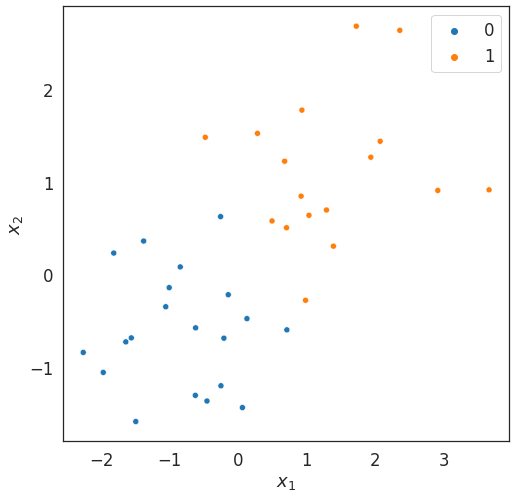

In [13]:
sns.set_style("white")
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [14]:
lsc = LeastSquareClassification()

weight_vector:  [[ 0.61155751  0.38844249]
 [-0.16572477  0.16572477]
 [-0.22310145  0.22310145]]


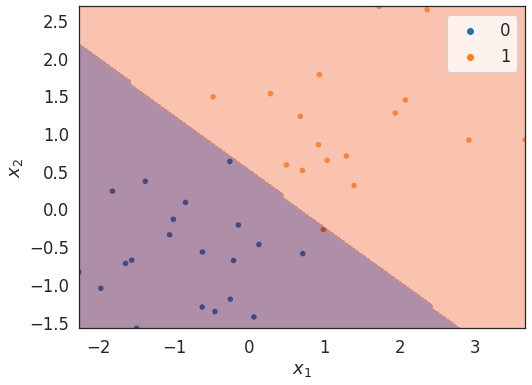

In [15]:
lsc.fit(x_train, y_train_trans, reg_rate=0)
print("weight_vector: ", lsc.w)
visualize_model(x_train, y_train, lsc)

## SGD

In [16]:
def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')
    plt.xlabel('Iter #')
    plt.ylabel('$\mathbf{J(w)}$')

In [17]:
lsc = LeastSquareClassification()
lsc.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)

array([[ 0.64078517,  0.35921483],
       [-0.20509536,  0.20509536],
       [-0.23176025,  0.23176025]])

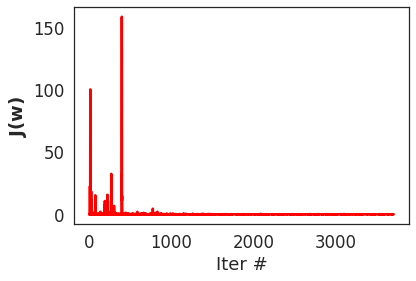

In [18]:
plot_learning_curve(lsc.err_all)

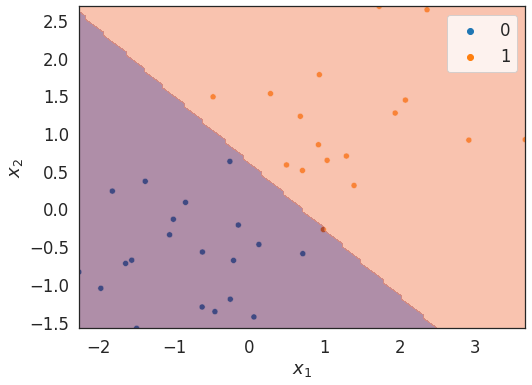

In [19]:
visualize_model(x_train, y_train, lsc)

In [20]:
lsc = LeastSquareClassification()
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 1e-3)

array([[ 0.59236285,  0.38028849],
       [-0.17651346,  0.17037324],
       [-0.20287935,  0.21850889]])

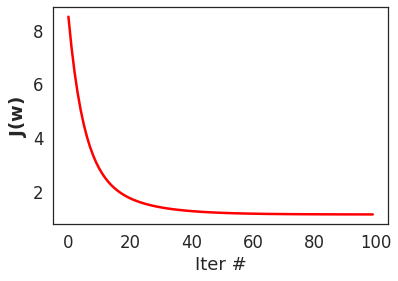

In [21]:
plot_learning_curve(lsc.err_all)

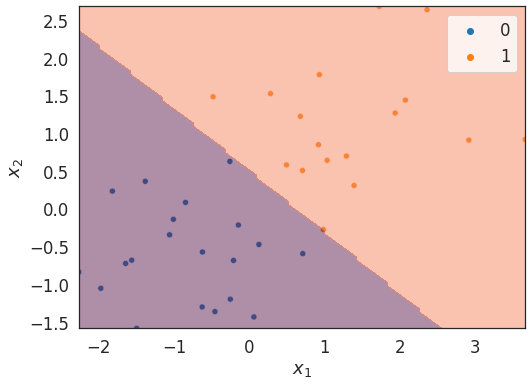

In [22]:
visualize_model(x_train, y_train, lsc)

### Evaluation

In [23]:
print(x_test.shape)
y_test_hat = lsc.predict(x_test)

(13, 3)


In [24]:
tp = np.where((y_test == 1) & (y_test_hat == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_test_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_test_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_hat == 0), 1, 0).sum()

In [25]:
def precision(tp, fp):
    if (tp + fp) == 0: return NaN
    return tp / (tp + fp)

def recall(tp, fn):
    if (tp + fn) == 0: return NaN
    return tp / (tp + fn)

def accuracy(tp, fp, tn, fn):
    return (tp + tn) / (tp + fp +tn + fn) 

def f1_score(pr, r):
    return 2 * ((pr * r) / (pr + r))

print("Precision: ", precision(tp, fp))
print("Recall: ", recall(tp, fn))
print("accuracy: ", accuracy(tp, fp, tn, fn))
print("f1 score: ", f1_score(precision(tp, fp), recall(tp, fn)))

Precision:  1.0
Recall:  0.75
accuracy:  0.8461538461538461
f1 score:  0.8571428571428571


## Demo 2: Linearly seperable binary classification with outliers

In [26]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_outliers=True)

In [27]:
print("\nShape of training feature matrix:", x_train.shape)
print("Shape of label vector:", y_train.shape)

print("\nShape of test feature matrix:", x_test.shape)
print("Shape of label vector:", y_test.shape)


Shape of training feature matrix: (41, 3)
Shape of label vector: (41,)

Shape of test feature matrix: (14, 3)
Shape of label vector: (14,)


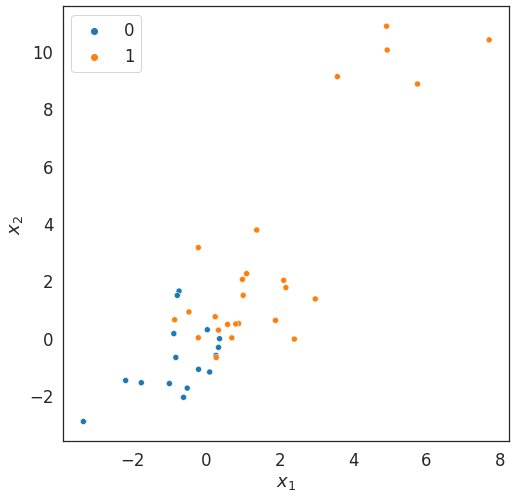

In [28]:
sns.set_style("white")
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [29]:
lsc = LeastSquareClassification()

weight_vector:  [[ 0.49853057  0.50146943]
 [-0.12764455  0.12764455]
 [-0.00352108  0.00352108]]


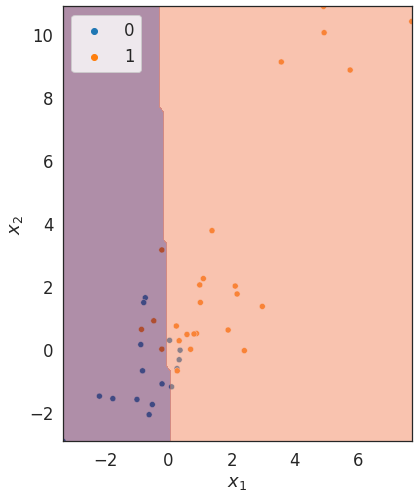

In [30]:
lsc.fit(x_train, y_train_trans, reg_rate=0)
print("weight_vector: ", lsc.w)
visualize_model(x_train, y_train, lsc)

### SGD

In [31]:
def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')
    plt.xlabel('Iter #')
    plt.ylabel('$\mathbf{J(w)}$')

In [32]:
lsc = LeastSquareClassification()
lsc.sgd(x_train, y_train_trans, num_epochs=1, reg_rate=0)

array([[  1405.22173683,   4137.85036075],
       [ -7985.95375111, -23534.53619823],
       [  7710.73316878,  22689.6016507 ]])

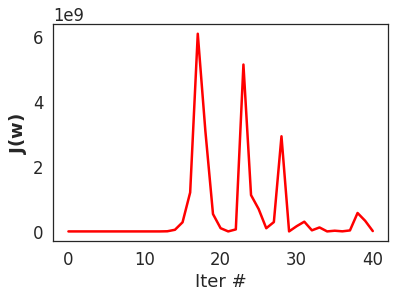

In [33]:
plot_learning_curve(lsc.err_all)

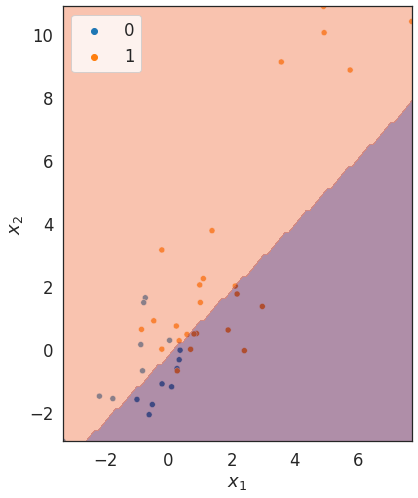

In [34]:
visualize_model(x_train, y_train, lsc)

In [35]:
lsc = LeastSquareClassification()
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 1e-3)

array([[ 0.4838311 ,  0.48641746],
       [-0.1256821 ,  0.12453491],
       [-0.00303224,  0.0069797 ]])

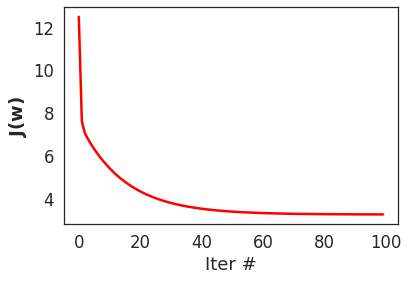

In [36]:
plot_learning_curve(lsc.err_all)

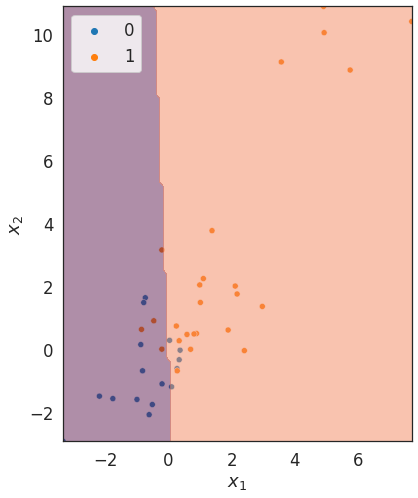

In [37]:
visualize_model(x_train, y_train, lsc)

In [38]:
print(x_test.shape)
y_test_hat = lsc.predict(x_test)

(14, 3)


In [39]:
tp = np.where((y_test == 1) & (y_test_hat == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_test_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_test_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_hat == 0), 1, 0).sum()

In [41]:
def precision(tp, fp):
    if (tp + fp) == 0: return 0
    return tp / (tp + fp)

def recall(tp, fn):
    if (tp + fn) == 0: return 0
    return tp / (tp + fn)

def accuracy(tp, fp, tn, fn):
    return (tp + tn) / (tp + fp +tn + fn) 

def f1_score(pr, r):
    return 2 * ((pr * r) / (pr + r))

print("Precision: ", precision(tp, fp))
print("Recall: ", recall(tp, fn))
print("accuracy: ", accuracy(tp, fp, tn, fn))
print("f1 score: ", f1_score(precision(tp, fp), recall(tp, fn)))

Precision:  0.8
Recall:  0.8
accuracy:  0.8571428571428571
f1 score:  0.8000000000000002


## Demo 3: Multiclass classification Section

In [42]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_class=True)

In [43]:
print("\nShape of training feature matrix:", x_train.shape)
print("Shape of label vector:", y_train.shape)

print("\nShape of test feature matrix:", x_test.shape)
print("Shape of label vector:", y_test.shape)


Shape of training feature matrix: (56, 3)
Shape of label vector: (56,)

Shape of test feature matrix: (19, 3)
Shape of label vector: (19,)


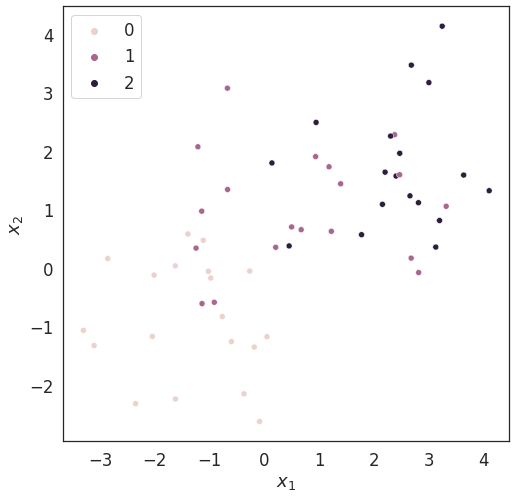

In [44]:
sns.set_style("white")
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [45]:
lsc = LeastSquareClassification()

weight_vector:  [[ 0.48454326  0.30362233  0.21183441]
 [-0.10241485 -0.02569678  0.12811163]
 [-0.15142301  0.08387527  0.06754774]]


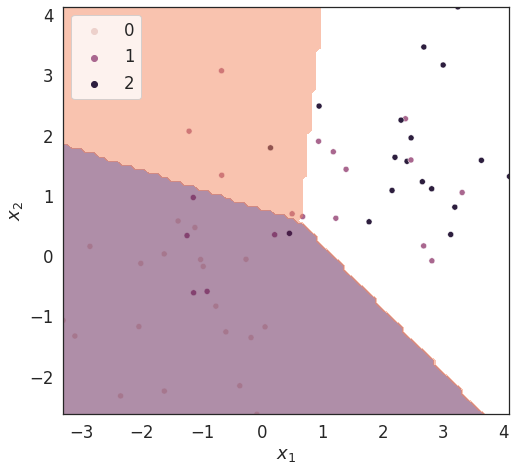

In [46]:
lsc.fit(x_train, y_train_trans, reg_rate=0)
print("weight_vector: ", lsc.w)
visualize_model(x_train, y_train, lsc)

In [47]:
from sklearn.metrics import classification_report
y_test_pred = lsc.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.00      0.00      0.00         6
           2       0.60      0.86      0.71         7

    accuracy                           0.58        19
   macro avg       0.41      0.56      0.47        19
weighted avg       0.42      0.58      0.49        19



## Demo 4: Polynomial least square classification

In [48]:
from sklearn.datasets import make_circles
x, y = make_circles()
x_poly = polynomial_transform(x, degree=2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

print("Shape of the feature matrix before transformation: ", x.shape)
print("Shape of the feature matrix after polynomial transformation: ", x_poly.shape)
y_train_trans = LabelTransformer().encode(y_train)
y_test_trans = LabelTransformer().encode(y_test)

Shape of the feature matrix before transformation:  (100, 2)
Shape of the feature matrix after polynomial transformation:  (100, 6)


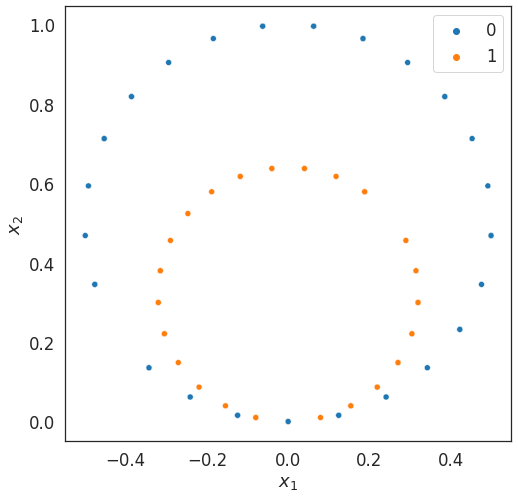

In [49]:
sns.set_style("white")
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

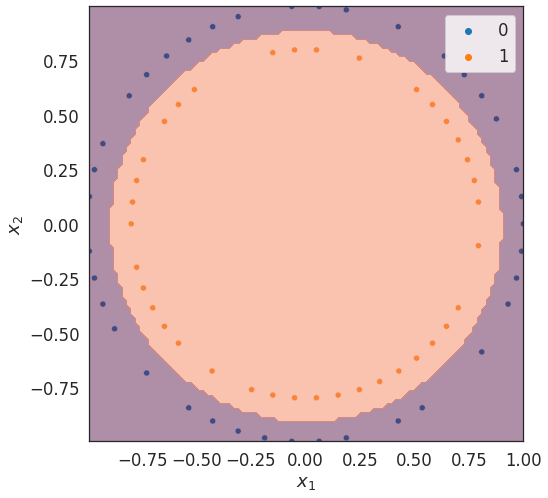

In [50]:
lsc_poly = LeastSquareClassification()
lsc_poly.fit(x_train, y_train_trans, reg_rate=1)
visualize_model(x_train, y_train, lsc_poly, degree=2)

In [51]:
from sklearn.metrics import classification_report
y_test_pred = lsc_poly.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

